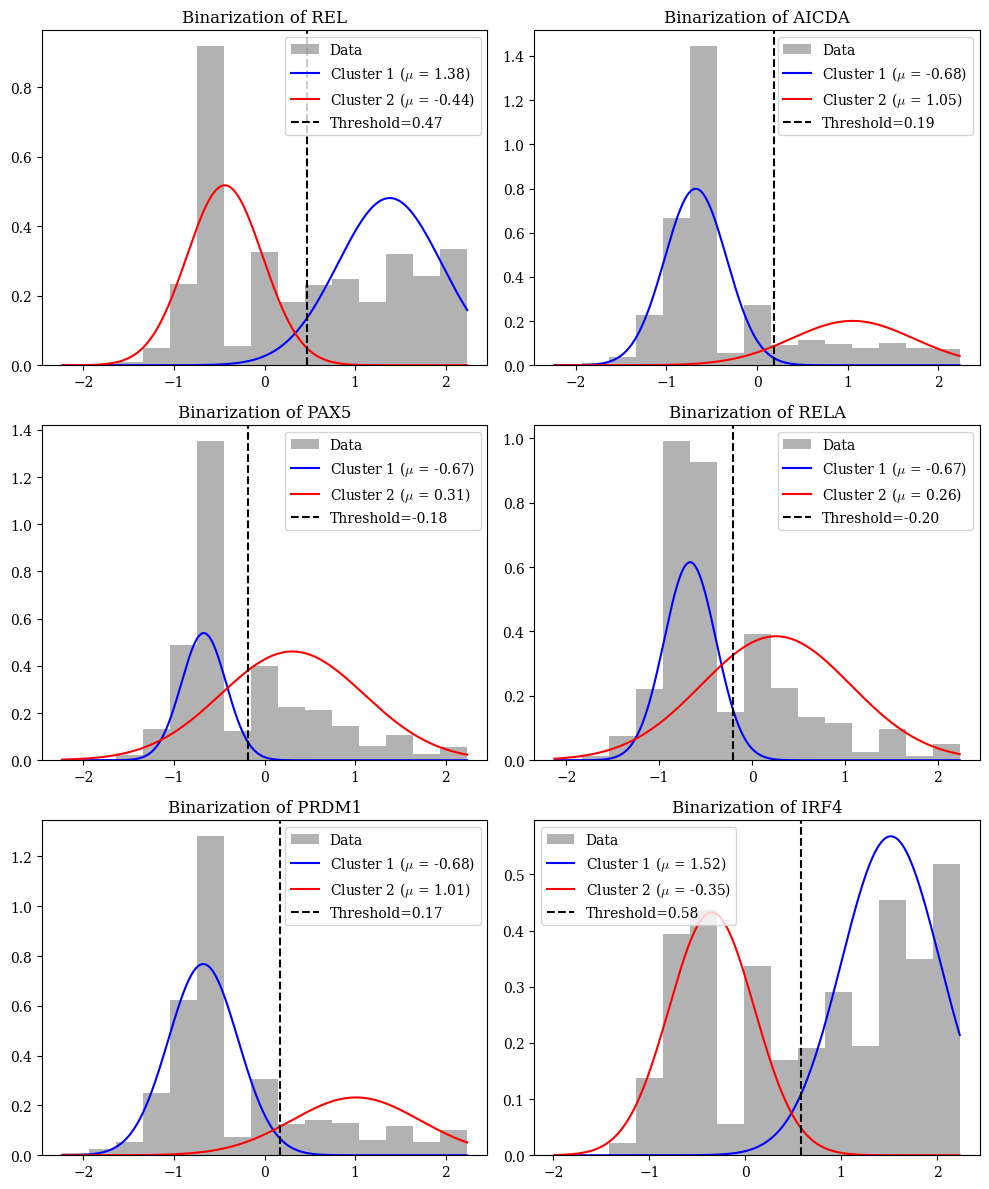

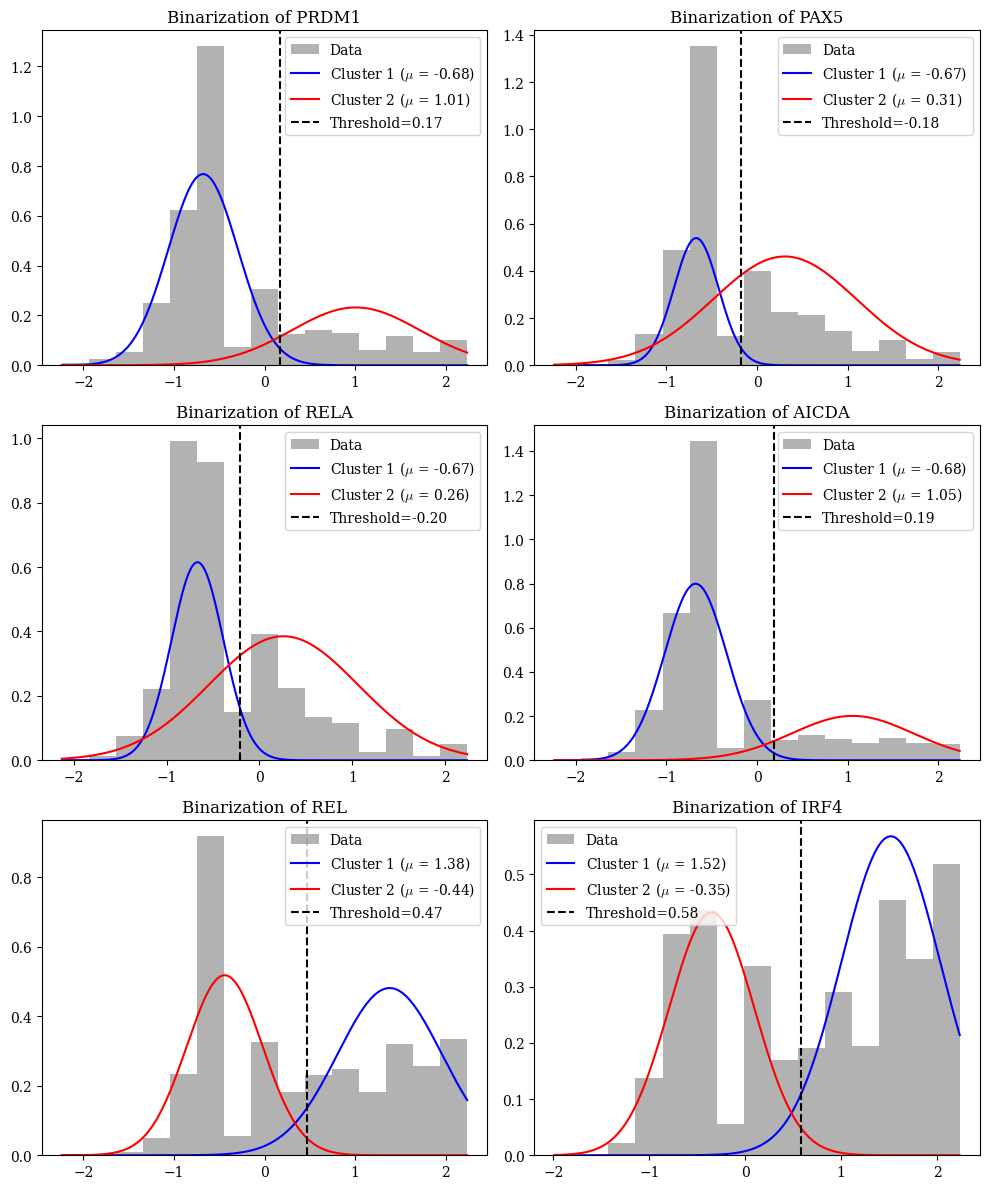

In [25]:
import numpy as np
import pandas as pd 
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from hilbertcurve.hilbertcurve import HilbertCurve

##########################################################################################################
##        STEP 1. APPLiCATION OF HILBERT CURVE
##########################################################################################################


def apply_hilbert_curve(expr_matrix):
    """"
    Applies the Hilbert curve to a gene expression matrix to determine the optimal order of genes.

    Input:
        expr_matrix (pd.DataFrame): Gene expression matrix (genes × patients).

    Output:
        hilbert_order (list): List of genes ordered according to the Hilbert curve.
        expr_matrix_scaled (pd.DataFrame):  Normalized gene expression matrix (genes × patients).
    """
    
    expr_matrix_log = np.log1p(expr_matrix)
    scaler = StandardScaler()
    expr_matrix_scaled = pd.DataFrame(scaler.fit_transform(expr_matrix_log), index = expr_matrix.index)

    pca = PCA(n_components=2)
    coords_2d = pca.fit_transform(expr_matrix_scaled)

    n_genes = expr_matrix_scaled.shape[0]
    size = 2 ** int(np.ceil(np.log2(n_genes)))
    
    coords_min = np.min(coords_2d, axis=0)
    coords_max = np.max(coords_2d, axis=0)
    coords_normalized = ((coords_2d - coords_min) / (coords_max - coords_min)) * (size - 1)
    coords_normalized = np.round(coords_normalized).astype(int)

    hilbert = HilbertCurve(int(np.log2(size)), 2)
    hilbert_indices = [hilbert.distance_from_point([x, y]) for x, y in coords_normalized]

    hilbert_sorted_indices = np.argsort(hilbert_indices)
    hilbert_order          = expr_matrix.index[hilbert_sorted_indices]

    expr_scaled_hilbert = expr_matrix_scaled.loc[hilbert_order]

    return hilbert_order, expr_scaled_hilbert

##########################################################################################################

import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

#################################################################
##        STEP 2 - BINARIZATION OF THE DATA USING GMM 
#################################################################

def binarize_with_gmm_with_plot(expr_matrix):
    """
    Binarize the gene expression matrix using a Gaussian mixture model (GMM).

    Input:
        expr_matrix (pd.DataFrame): Gene expression matrix (genes × patients).

    Output:
        expr_binarized (pd.DataFrame): Binarized matrix (0 or 1).
    """

    genes          = expr_matrix.index
    patients       = expr_matrix.columns
    expr_binarized = pd.DataFrame(index = genes, columns = patients)

    fig, axes = plt.subplots(len(genes) // 2, 2, figsize=(10, len(genes) * 2))
    axes = axes.flatten()

    for idx, gene in enumerate(genes):
        data = expr_matrix.loc[gene].values.reshape(-1, 1)

        gmm = GaussianMixture(n_components = 2, random_state = 0)
        gmm.fit(data)

        means = gmm.means_.flatten()
        covariances = gmm.covariances_.flatten()
        weights = gmm.weights_.flatten()

        x_star = (means[0] + means[1]) / 2

        activated = (data > x_star).astype(int)
        expr_binarized.loc[gene] = activated.flatten()

        # Plot the different genes
        ax = axes[idx]
        ax.hist(data, bins = 15, density = True, alpha = 0.6, color = 'gray', label = 'Data')
        
        x_values = np.linspace(data.min(), data.max(), 1000)
        y1 = weights[0] * np.exp(-0.5 * ((x_values - means[0])**2) / covariances[0])
        y2 = weights[1] * np.exp(-0.5 * ((x_values - means[1])**2) / covariances[1])

        ax.plot(x_values, y1, color = 'blue', label = f'Cluster 1 ($\mu$ = {means[0]:.2f})')
        ax.plot(x_values, y2, color = 'red',  label = f'Cluster 2 ($\mu$ = {means[1]:.2f})')
        ax.axvline(x = x_star, color = 'black', linestyle='--', label=f'Threshold={x_star:.2f}')
        ax.set_title(f'Binarization of {gene}')
        ax.legend()

    plt.tight_layout()
    plt.show()

    return expr_binarized

def binarize_with_gmm(expr_matrix):
    """
    Binarize the gene expression matrix using a Gaussian mixture model (GMM).

    Input:
        expr_matrix (pd.DataFrame): Gene expression matrix (genes × patients).

    Output:
        expr_binarized (pd.DataFrame): Binarized matrix (0 or 1).
    """

    genes          = expr_matrix.index
    patients       = expr_matrix.columns
    expr_binarized = pd.DataFrame(index = genes, columns = patients)


    for idx, gene in enumerate(genes):
        data = expr_matrix.loc[gene].values.reshape(-1, 1)

        gmm = GaussianMixture(n_components = 2, random_state = 0)
        gmm.fit(data)

        means = gmm.means_.flatten()
        covariances = gmm.covariances_.flatten()
        weights = gmm.weights_.flatten()

        x_star = (means[0] + means[1]) / 2

        activated = (data > x_star).astype(int)
        expr_binarized.loc[gene] = activated.flatten()

    return expr_binarized

##########################################################################################################

expr_matrix   = pd.read_csv("expr_matrix.txt", sep="\t", index_col = 0)

gene_order  = ['REL','AICDA', 'PAX5', 'RELA', 'PRDM1', 'IRF4'] # take randomly 
expr_matrix = expr_matrix.loc[gene_order]

#### Define the original data ####
expr_matrix_log = np.log1p(expr_matrix)
scaler = StandardScaler()
expr_scaled_original = pd.DataFrame(scaler.fit_transform(expr_matrix_log), index = expr_matrix.index)

expr_binarized_original = binarize_with_gmm_with_plot(expr_scaled_original)

#### Define the hilbert data ####
hilbert_order, expr_scaled_hilbert = apply_hilbert_curve(expr_matrix)

expr_binarized_hilbert = binarize_with_gmm_with_plot(expr_scaled_hilbert)
expr_binarized_hilbert.to_csv("expr_binarized_hilbert.txt", sep = "\t")

##########################################################################################################

In [18]:
##########################################################################################################
##        STEP 3 - STATE VECTOR REPRESENTATION FOR THE MPS
##########################################################################################################

from itertools import product

def state_vector_representation(binarized_expr):
    """
    Take the binarized matrix and construct a rho vector state.

    Input:
        binarized (pd.DataFrame): Binarized and sorted gene expression matrix (genes × patients).

    Output:
        state_vector: Matrix of dimension 2^N where N are the genes with root(probability).
    """ 

    sequences  = binarized_expr.apply(lambda col: ''.join(col.astype(str)), axis = 0)
    freq_table = sequences.value_counts()

    num_genes    = binarized_expr.shape[0]
    combinations = [''.join(map(str, comb)) for comb in product([0, 1], repeat = num_genes)]

    num_patients  = binarized_expr.shape[1]
    probabilities = []
    for seq in combinations:
        freq_seq = freq_table.get(seq, 0) 
        prob_seq = freq_seq / num_patients
        probabilities.append(prob_seq)
    
    probabilities = np.array(probabilities)
    print("La suma total de probabilidades es :", np.round(np.sum(probabilities), 5))

    state_vector  = np.sqrt(probabilities)
    return state_vector

##########################################################################################################

state_vector_original = state_vector_representation(expr_binarized_original)
print("The representation of the state vector of the original order binarized matrix is:")
print(np.round(state_vector_original, 5))

state_vector_hilbert  = state_vector_representation(expr_binarized_hilbert)
print("The representation of the state vector of the hilbert order binarized matrix is:")
print(np.round(state_vector_hilbert, 5))

La suma total de probabilidades es : 1.0
The representation of the state vector of the original order binarized matrix is:
[0.      0.28098 0.16295 0.25864 0.11878 0.19513 0.09656 0.14609 0.12275
 0.22238 0.07243 0.11698 0.25512 0.16153 0.05122 0.05649 0.12475 0.16153
 0.0644  0.08336 0.08546 0.09127 0.0342  0.02526 0.10898 0.11091 0.02977
 0.03094 0.07268 0.05191 0.01031 0.      0.25141 0.27524 0.12728 0.13327
 0.18109 0.17542 0.07831 0.04763 0.21143 0.21076 0.07413 0.04726 0.15583
 0.10701 0.03036 0.      0.16946 0.12115 0.04495 0.02526 0.09747 0.0421
 0.01191 0.      0.13234 0.05773 0.02147 0.      0.05325 0.      0.
 0.     ]
La suma total de probabilidades es : 1.0
The representation of the state vector of the hilbert order binarized matrix is:
[0.      0.28098 0.25141 0.27524 0.12475 0.16153 0.16946 0.12115 0.11878
 0.19513 0.18109 0.17542 0.08546 0.09127 0.09747 0.0421  0.12275 0.22238
 0.21143 0.21076 0.10898 0.11091 0.13234 0.05773 0.25512 0.16153 0.15583
 0.10701 0.07268 0.05

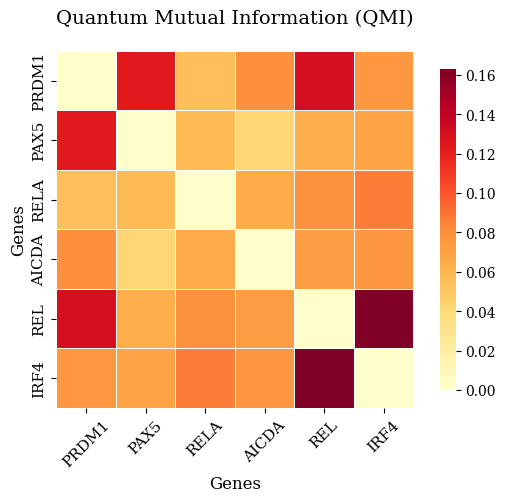

genes     PRDM1      PAX5      RELA     AICDA       REL      IRF4
genes                                                            
PRDM1  0.000000  0.122490  0.054188  0.080651  0.130046  0.076324
PAX5   0.122490  0.000000  0.056849  0.041788  0.062494  0.069418
RELA   0.054188  0.056849  0.000000  0.065076  0.078403  0.087227
AICDA  0.080651  0.041788  0.065076  0.000000  0.072904  0.076719
REL    0.130046  0.062494  0.078403  0.072904  0.000000  0.163091
IRF4   0.076324  0.069418  0.087227  0.076719  0.163091  0.000000


In [20]:
import math
from scipy.linalg import svd
import ncon

##########################################################################################################
##        STEP 4 - MPS REPRESENTATION AND PROBABILITIES EXTRACTION
##########################################################################################################

##########################################################################################################
##  STEP 4.1 - Decomposition of the state vector into a MPS
##########################################################################################################
def decompose_to_mps(state_vector, num_qubits):
    '''
    This function transforms the state vector into an MPS (Matrix Product Representation).

    Input:
        state_vector (matrix): this is a matrix where the probability amplitude is written for each sequence.
        num_qubits (number): this is the number of qubits that will be used for the representation, that is, the number of genes in this case.

    Output:
        mps (array): this is an array of “matrices” of combinations of u of the number of genes/qubits.
    '''
    tensor = state_vector.reshape([2] * num_qubits)
    mps = []
    l_dim = 1 
    max_bond_dim = 2 ** (num_qubits // 2)  

    for i in range(num_qubits - 1):
        tensor   = tensor.reshape((l_dim * 2, -1))  
        u, s, vh = svd(tensor, full_matrices=False)

        new_bond = min(len(s), max_bond_dim)  
        u = u[:, :new_bond].reshape(l_dim, 2, new_bond)
        mps.append(u)

        tensor = np.dot(np.diag(s[:new_bond]), vh[:new_bond, :])
        l_dim  = new_bond

    mps.append(tensor.reshape(l_dim, 2, -1))  # Last tensor
    return mps


###########################################################################################################
##  STEP 4.2 - Calculate the marginal probabilities and joint probabilities of the MPS
###########################################################################################################

##### 4.2.1. Marginal probability
###########################################################################################################
def get_local_density_matrix(mps, selected_tensor, tol=1e-10):
    # Initialize the right and left environments as identity matrices
    right_env = np.array([[1.0]])
    left_env = np.array([[1.0]])
    # Contraction to obtain the right environment
    for r_envir in range(len(mps) - 1, selected_tensor, -1):
        right_env = ncon.ncon([mps[r_envir], np.conjugate(mps[r_envir]), right_env],
                              [[-1, 3, 1], [-2, 3, 2], [1, 2]])
    # Contraction to obtain the left environment
    for l_envir in range(0, selected_tensor):
        left_env = ncon.ncon([left_env, mps[l_envir], np.conjugate(mps[l_envir])],
                             [[1, 3], [1, 2, -1], [3, 2, -2]])
    
    rho_l = ncon.ncon([left_env, mps[selected_tensor], np.conjugate(mps[selected_tensor]), right_env],
                      [[1, 4], [1, -1, 2], [4, -2, 3], [2, 3]])
    
    trace_rho = np.trace(rho_l)
    if trace_rho != 0:
        rho_l /= trace_rho
    
    rho_l[np.abs(rho_l) < tol] = 0
    return rho_l


##### 4.2.1. Joint probability
#########################################################################################################
def get_two_site_density_matrix(mps, l1, l2):
    if l1 > l2:
        l1, l2 = l2, l1

    right_env = np.array([[1.0]])
    left_env = np.array([[1.0]])
    # Build the right environment up to l2
    for r_env in range(len(mps) - 1, l2, -1):
        right_env = ncon.ncon([mps[r_env], np.conjugate(mps[r_env]), right_env],
                              [[-1, 3, 1], [-2, 3, 2], [1, 2]])
    # Build the left environment up to l1
    for l_env in range(0, l1):
        left_env = ncon.ncon([left_env, mps[l_env], np.conjugate(mps[l_env])],
                             [[1, 3], [1, 2, -1], [3, 2, -2]])
    # Checking whether l1 and l2 are adjacent
    if l2 == l1 + 1:
        rho_2site = ncon.ncon([left_env, mps[l1], mps[l2], np.conjugate(mps[l1]), np.conjugate(mps[l2]), right_env],
                              [[1, 5], [1, -1, 2], [2, -2, 3], [5, -3, 4], [4, -4, 6], [3, 6]])
    else:
        middle_env = ncon.ncon([mps[l1 + 1], np.conjugate(mps[l1 + 1])], [[-1, 1, -2], [-4, 1, -3]])
        for m_envir in range(l1 + 2, l2):
            middle_env = ncon.ncon([middle_env, mps[m_envir], np.conjugate(mps[m_envir])],
                                   [[-1, 1, 2, -4], [1, 3, -2], [2, 3, -3]])
        inter1 = ncon.ncon([left_env, mps[l1], np.conjugate(mps[l1])],
                           [[1, 2], [1, -1, -2], [2, -4, -3]])
        inter2 = ncon.ncon([right_env, mps[l2], np.conjugate(mps[l2])],
                           [[1, 2], [-2, -1, 1], [-3, -4, 2]])
        rho_2site = ncon.ncon([inter1, inter2, middle_env],
                              [[-1, 1, 2, -3], [-2, 3, 4, -4], [1, 3, 4, 2]])

    rho_2site = rho_2site.reshape(4, 4)
    
    # Prove Hermitian and trace = 1
    if not np.allclose(rho_2site, rho_2site.conj().T, atol = 1e-10):
        print("Warning: rho_2site is not Hermitian")

    trace_rho = np.trace(rho_2site)
    if not np.isclose(trace_rho, 1.0, atol=1e-10):
        print(f"Warning: Trace of rho_2site is not 1, but {trace_rho}")
    return rho_2site

###########################################################################################################
##  STEP 4.3 - Calculate Von Neumman entropies to calculate Quantum Mutual Information (QMI)
###########################################################################################################

##### 4.3.1. Calculate the Von Neumann Entropies using the previous rho-s
############################################################################################################
def is_valid_density_matrix(rho, epsilon = 1e-10):

    if not np.allclose(rho, rho.conj().T, atol=epsilon):
        print("La matriz no es Hermitiana.")
        return False

    trace = np.trace(rho)
    if not np.isclose(trace, 1, atol=epsilon):
        print(f"Traza incorrecta: {trace}")
        return False
    
    eigenvalues = np.linalg.eigvalsh(rho)  
    if np.any(eigenvalues < -epsilon):
        print("Valores propios negativos encontrados.")
        return False
    return True

def von_neumann_entropy(rho, epsilon = 1e-3):
    eigenvalues = np.linalg.eigvalsh(rho)
    eigenvalues = np.where(eigenvalues > epsilon, eigenvalues, 0)
    # Avoid the logarithm of 0 using np.log(eigenvalues, where=eigenvalues>0)
    entropy = -np.sum(eigenvalues * np.log(eigenvalues, where = (eigenvalues > 0)))
    return entropy

##### 4.3.2. Calculate Quantum Mutual Information (QMI) 
############################################################################################################
def mutual_information(mps, qubit_A, qubit_B):
    rho_A = get_local_density_matrix(mps, qubit_A)
    rho_B = get_local_density_matrix(mps, qubit_B)
    
    rho_AB = get_two_site_density_matrix(mps, qubit_A, qubit_B)
    
    if not is_valid_density_matrix(rho_A) or not is_valid_density_matrix(rho_B) or not is_valid_density_matrix(rho_AB):
        print(f"Advertencia: Matriz de densidad no válida para qubits {qubit_A} y {qubit_B}.")
        return 0.0 
    
    S_A = von_neumann_entropy(rho_A)
    S_B = von_neumann_entropy(rho_B)
    S_AB = von_neumann_entropy(rho_AB)
    
    I_AB = S_A + S_B - S_AB
    return I_AB

##### 4.3.3. Calculate the correlation matrix of Quantum Mutual Information (QMI)
############################################################################################################
def correlation_matrix(mps, num_qubits):
    correlation_mat = np.zeros((num_qubits, num_qubits))
    
    # Calculate the mutual information for each pair of qubits.
    for i in range(num_qubits):
        for j in range(num_qubits):
            if i != j:  
                I_ij = mutual_information(mps, i, j) 
                correlation_mat[i, j] = I_ij
    
    return correlation_mat

############################################################################################################
num_qubits  = len(hilbert_order)
mps_hilbert = decompose_to_mps(state_vector_hilbert,  num_qubits)
MI_matrix_hilbert  = correlation_matrix(mps_hilbert,  num_qubits)

df_hilbert    = pd.DataFrame(MI_matrix_hilbert, index = hilbert_order, columns = hilbert_order)

from matplotlib import rcParams

# Set LaTeX-like font
rcParams['font.family'] = 'serif'
rcParams['mathtext.fontset'] = 'cm'

# Create heatmap without numbers, just color intensity
plt.figure(figsize=(6, 5))
sns.heatmap(
    df_hilbert,
    annot=False,
    cmap='YlOrRd',
    linewidths = 0.5,
    square = True,
    cbar_kws={"shrink": 0.9}
)
plt.title("Quantum Mutual Information (QMI)", fontsize = 14, pad=20)
plt.xlabel("Genes", fontsize = 12)
plt.ylabel("Genes", fontsize = 12)
plt.xticks(rotation=45, fontsize = 11)
plt.yticks(fontsize = 11)
plt.tight_layout()
plt.show()
print(df_hilbert)

In [35]:
from tqdm import tqdm
from statsmodels.stats.multitest import multipletests

##########################################################################################################
##        STEP 5 - APPLICATION OF PERMUTATION TEST
##########################################################################################################
def permute_within_rows_partial(matrix, fraction_permuted = 1.0, noise_std = 0, random_seed = None):
    """
     Partially permutes the columns (patients) within each row (gene) in a more robust manner.
    
    Input:
        matrix: Gene expression DataFrame (genes × patients).
        fraction_permuted: Fraction of columns to permute (0 ≤ f ≤ 1). If 1, permutes all.
        noise_std: standard deviation of Gaussian noise (0 to add no noise).
        random_seed: seed for reproducibility (optional).
        
    Output:
        Partially permuted DataFrame with the same index and columns as the input.
    """

    if random_seed is not None:
        np.random.seed(random_seed)
    
    permuted_matrix = matrix.copy()
    num_columns = matrix.shape[1]
    
    if fraction_permuted == 0:
        return permuted_matrix
    
    num_perm = max(1, int(round(fraction_permuted * num_columns)))
    
    for gene in permuted_matrix.index:
        row_values = permuted_matrix.loc[gene].values.copy()
        perm_indices = np.random.choice(num_columns, size = num_perm, replace = False)
        
        permuted_values = row_values[perm_indices]
        np.random.shuffle(permuted_values)
        
        # # Añadir ruido de forma vectorizada
        # if noise_std > 0:
        #     permuted_values += np.random.normal(0, noise_std, size=num_perm)
        
        row_values[perm_indices] = permuted_values
        permuted_matrix.loc[gene] = row_values
    
    return permuted_matrix

##########################################################################################################

def combined_permutation_test(
    expr_matrix, 
    MI_matrix_original, 
    hilbert_order,
    num_qubits,
    n_perm=100,
    fraction_permuted=0.6,
    noise_std=0,
    alpha=0.05,
    random_seed = None,
    alternative = 'two-tailed'  # Added alternative hypothesis parameter
):
    """
    Enhanced permutation test for pairwise mutual information matrix.
    
    Args:
        expr_matrix: Original gene expression matrix
        MI_matrix_original: Original mutual information matrix (2D)
        hilbert_order: Hilbert order of genes
        num_qubits: Number of qubits/genes
        n_perm: Number of permutations
        fraction_permuted: Fraction of columns to permute
        noise_std: Standard deviation of noise
        alpha: Significance level
        random_seed: Seed for reproducibility
        alternative: Type of test - 'two-tailed', 'one-tailed-right', or 'one-tailed-left'
        
    Returns:
        correlation_matrix_df: DataFrame with original MI values
        p_values_df: DataFrame with p-values for each pair
        null_distributions: Dictionary with null distributions for each gene pair
    """
    
    if random_seed is not None:
        np.random.seed(random_seed)

    genes = hilbert_order
    n_genes = len(genes)
    null_distributions = {}

    all_permutations = np.zeros((n_perm, n_genes, n_genes))
    all_permutations[0] = MI_matrix_original

    for perm in tqdm(range(1, n_perm), desc = "Running Permutations"):
        permuted_matrix = permute_within_rows_partial(
            expr_matrix, fraction_permuted=fraction_permuted, noise_std=noise_std
        )
        _, expr_scaled = apply_hilbert_curve(permuted_matrix)
        expr_binarized = binarize_with_gmm(expr_scaled)
        state_vector = state_vector_representation(expr_binarized)
        mps = decompose_to_mps(state_vector, num_qubits)
        MI_permuted = correlation_matrix(mps, num_qubits)
        all_permutations[perm] = MI_permuted

    for i in range(n_genes):
        for j in range(i + 1, n_genes):
            pair_key = f"({genes[i]},{genes[j]})"
            null_distributions[pair_key] = []

    for perm in range(1, n_perm):
        for i in range(n_genes):
            for j in range(i + 1, n_genes):
                pair_key = f"({genes[i]},{genes[j]})"
                null_distributions[pair_key].append(all_permutations[perm, i, j])

    p_values = np.zeros((n_genes, n_genes))
    
    for i in range(n_genes):
        for j in range(i + 1, n_genes):
            null_dist = null_distributions[f"({genes[i]},{genes[j]})"]
            original_val = MI_matrix_original[i, j]

            if alternative == 'two-tailed':
                extreme_count = np.sum(np.abs(null_dist) >= np.abs(original_val))
            elif alternative == 'one-tailed-right':
                extreme_count = np.sum(null_dist >= original_val)
            elif alternative == 'one-tailed-left':
                extreme_count = np.sum(null_dist <= original_val)
            else:
                raise ValueError("alternative must be 'two-tailed', 'one-tailed-right', or 'one-tailed-left'")

            p_val = (extreme_count + 1) / (n_perm + 1)
            p_values[i, j] = p_val
            p_values[j, i] = p_val  

 
    correlation_matrix_df = pd.DataFrame(MI_matrix_original, index=genes, columns=genes)
    p_values_df = pd.DataFrame(p_values, index=genes, columns=genes)
    
    return correlation_matrix_df, p_values_df, null_distributions

##########################################################################################################
corr_matrix, p_value_matrix, null_dists = combined_permutation_test(
    expr_matrix, 
    MI_matrix_hilbert, 
    hilbert_order,
    num_qubits,
    n_perm = 10,
    fraction_permuted = 0.6,
    noise_std  =0,
    alternative = 'two-tailed',  
    random_seed = 42
)

print("Correlation Matrix:")
print(corr_matrix.head())

print("\nP-value Matrix:")
print(p_value_matrix.head())

Running Permutations:  11%|█         | 1/9 [00:01<00:14,  1.76s/it]

La suma total de probabilidades es : 1.0


Running Permutations:  22%|██▏       | 2/9 [00:03<00:12,  1.75s/it]

La suma total de probabilidades es : 1.0


Running Permutations:  33%|███▎      | 3/9 [00:05<00:10,  1.80s/it]

La suma total de probabilidades es : 1.0


Running Permutations:  44%|████▍     | 4/9 [00:07<00:08,  1.80s/it]

La suma total de probabilidades es : 1.0


Running Permutations:  56%|█████▌    | 5/9 [00:08<00:07,  1.75s/it]

La suma total de probabilidades es : 1.0


Running Permutations:  67%|██████▋   | 6/9 [00:10<00:05,  1.76s/it]

La suma total de probabilidades es : 1.0


Running Permutations:  78%|███████▊  | 7/9 [00:12<00:03,  1.74s/it]

La suma total de probabilidades es : 1.0


Running Permutations:  89%|████████▉ | 8/9 [00:14<00:01,  1.75s/it]

La suma total de probabilidades es : 1.0


Running Permutations: 100%|██████████| 9/9 [00:15<00:00,  1.75s/it]

La suma total de probabilidades es : 1.0
Correlation Matrix:
genes     PRDM1      PAX5      RELA     AICDA       REL      IRF4
genes                                                            
PRDM1  0.000000  0.122490  0.054188  0.080651  0.130046  0.076324
PAX5   0.122490  0.000000  0.056849  0.041788  0.062494  0.069418
RELA   0.054188  0.056849  0.000000  0.065076  0.078403  0.087227
AICDA  0.080651  0.041788  0.065076  0.000000  0.072904  0.076719
REL    0.130046  0.062494  0.078403  0.072904  0.000000  0.163091

P-value Matrix:
genes     PRDM1      PAX5      RELA     AICDA       REL      IRF4
genes                                                            
PRDM1  0.000000  0.090909  0.909091  0.181818  0.090909  0.818182
PAX5   0.090909  0.000000  0.818182  0.909091  0.818182  0.909091
RELA   0.909091  0.818182  0.000000  0.090909  0.090909  0.181818
AICDA  0.181818  0.909091  0.090909  0.000000  0.272727  0.545455
REL    0.090909  0.818182  0.090909  0.272727  0.000000  0.63636

In [32]:
####################################################################
##        STEP 6 - PERMUTATION TEST FOR 3 QUBITS
####################################################################
import numpy as np
import ncon as ncon
###########################################################################################################
##  STEP 6.1 - Joint probability (with 3 genes)
###########################################################################################################

def get_three_site_density_matrix(mps, i, j, k):
    """
    Calculate the reduced density matrix for 3 sites in an MPS represented as a list of tensors.
    Input:
        mps: List of tensors [A1, A2, ..., An] where each Ai is a rank 3 tensor (left, phys, right)
        i, j, k: Site indices (0-based)
    Output:
        3-site density matrix (8x8)
    """
    sites = sorted([i, j, k])
    l1, l2, l3 = sites
    # 1. LEFT ENVIRONMENT 
    left_env = np.array([[1.0]])
    for l in range(l1):
        left_env = ncon.ncon(
            [left_env, mps[l], np.conj(mps[l])],
            [[1, 3], [1, 2, -1], [3, 2, -2]]
        )
    # 2. RIGHT ENVIRONMENT 
    right_env = np.array([[1.0]])
    for r in range(len(mps)-1, l3, -1):
        right_env = ncon.ncon(
            [mps[r], np.conj(mps[r]), right_env],
            [[-1, 3, 1], [-2, 3, 2], [1, 2]]
        )
    # 3. MIDDLE ENVIRONMENTS 
    def build_mid_env(start, end):
        env = None
        for m in range(start+1, end):
            if env is None:
                env = ncon.ncon(
                    [mps[m], np.conj(mps[m])],
                    [[-1, 1, -2], [-3, 1, -4]]
                )
            else:
                env = ncon.ncon(
                    [env, mps[m], np.conj(mps[m])],
                    [[-1, 1, -3, 2], [1, 3, -2], [2, 3, -4]]
                )
        return env
    mid_env_1 = build_mid_env(l1, l2) if (l2 - l1 > 1) else None
    mid_env_2 = build_mid_env(l2, l3) if (l3 - l2 > 1) else None

    A, B, C = mps[l1], mps[l2], mps[l3]
    A_conj, B_conj, C_conj = np.conj(A), np.conj(B), np.conj(C)

    inter1 = ncon.ncon(
        [left_env, A, A_conj],
        [[1, 2], [1, -1, -3], [2, -2, -4]]
    )
 
    if mid_env_1 is not None:
        inter1 = ncon.ncon(
            [inter1, mid_env_1],
            [[-1, -2, 1, 2], [1, -3, 2, -4]]
        )
    inter2 = ncon.ncon(
        [inter1, B, B_conj],
        [[-1, -2, 1, 2], [1, -3, -5], [2, -4, -6]]
    )

    if mid_env_2 is not None:
        inter2 = ncon.ncon(
            [inter2, mid_env_2],
            [[-1, -2, -3, -4, 1, 2], [1, -5, 2, -6]]
        )

    rho = ncon.ncon(
        [inter2, C, C_conj, right_env],
        [[-1, -2, -3, -4, 1, 2], [1, -5, 3], [2, -6, 4], [3, 4]]
    )
   
    rho = np.transpose(rho, (0, 2, 4, 1, 3, 5)).reshape(8, 8)
    
    if not np.allclose(rho, rho.conj().T, atol=1e-10):
        print("Warning: Matriz de densidad no es Hermitiana")
    trace_rho = np.trace(rho)
    if not np.isclose(trace_rho, 1.0, atol=1e-10):
        print(f"Warning: Traza no es 1, sino {trace_rho}")
        rho = rho / trace_rho  
    return rho

###########################################################################################################
##  STEP 6.2 - Mutual Information Calulation with 3 qubits
###########################################################################################################
def mutual_information_3qubits(mps, i, j, k):
    """
    Calculate the quantum mutual information for 3 qubits in an MPS.
    Input:
        mps: MPS state.
        i, j, k: Qubit indices.
    Output:
        I_ijk: Mutual information of 3 qubits.
    """
    rho_i = get_local_density_matrix(mps, i)
    rho_j = get_local_density_matrix(mps, j)
    rho_k = get_local_density_matrix(mps, k)

    rho_ij = get_two_site_density_matrix(mps, i, j)
    rho_ik = get_two_site_density_matrix(mps, i, k)
    rho_jk = get_two_site_density_matrix(mps, j, k)

    rho_ijk = get_three_site_density_matrix(mps, i, j, k)
    
    S_i = von_neumann_entropy(rho_i)
    S_j = von_neumann_entropy(rho_j)
    S_k = von_neumann_entropy(rho_k)

    S_ij = von_neumann_entropy(rho_ij)
    S_ik = von_neumann_entropy(rho_ik)
    S_jk = von_neumann_entropy(rho_jk)

    S_ijk = von_neumann_entropy(rho_ijk)
    
    I_ijk = S_i + S_j + S_k - S_ij - S_ik - S_jk + S_ijk
    return I_ijk 

###########################################################################################################
##  STEP 6.3 - Correlation Matrix calculation for 3 qubits
###########################################################################################################

def correlation_matrix_3qubits(mps, num_qubits):
    """
    Calculates the mutual information matrix for all trios of qubits.
    Args:
        mps: MPS state.
        num_qubits: Total number of qubits.
    Returns:
        correlation_mat_3: 3D matrix (num_qubits x num_qubits x num_qubits) with I(X_i; X_j; X_k).
    """
    correlation_mat_3 = np.zeros((num_qubits, num_qubits, num_qubits))
    for i in range(num_qubits):
        for j in range(i+1, num_qubits):
            for k in range(j+1, num_qubits):
                I_ijk = mutual_information_3qubits(mps, i, j, k)
                correlation_mat_3[i, j, k] = I_ijk
                correlation_mat_3[i, k, j] = I_ijk
                correlation_mat_3[j, i, k] = I_ijk
                correlation_mat_3[j, k, i] = I_ijk
                correlation_mat_3[k, i, j] = I_ijk
                correlation_mat_3[k, j, i] = I_ijk
    return correlation_mat_3

def print_3qubit_correlations(corr_mat):
    num_qubits = corr_mat.shape[0]
    print("Correlaciones de 3 qubits (i < j < k):")
    for i in range(num_qubits):
        for j in range(i+1, num_qubits):
            for k in range(j+1, num_qubits):
                print(f"I({i},{j},{k}) = {corr_mat[i,j,k]:.6f}")

###########################################################################################################

MI_matrix_hilbert_3qubits = correlation_matrix_3qubits(mps_hilbert,  num_qubits)
# print_3qubit_correlations(MI_matrix_hilbert_3qubits)

###########################################################################################################

def permutation_test_3qubits(
    expr_matrix,
    MI_matrix_original_3qubits,
    hilbert_order,
    num_qubits,
    n_perm = 100,
    fraction_permuted = 0.6,
    noise_std = 0,
    random_seed = None,
    alternative = 'two-tailed'
):
    """
    Permutation test for 3-qubit mutual information matrix.
    
    Args:
        expr_matrix: Original gene expression matrix
        MI_original_3qubits_matrix: Original 3D mutual information matrix
        hilbert_order: Hilbert order of genes
        num_qubits: Number of qubits/genes
        n_perm: Number of permutations
        fraction_permuted: Fraction of columns to permute
        noise_std: Standard deviation of noise
        random_seed: Seed for reproducibility
        alternative: ‘two-tailed’ or ‘one-tailed’ (right)
        
    Returns:
        p_values_df: DataFrame with p-values for each trio
        null_distributions: Dictionary with null distributions per trio
    """
    if random_seed is not None:
        np.random.seed(random_seed)
    
    genes = hilbert_order
    n_genes = len(genes)
    null_distributions = {}
    
    trios = []
    p_values = []
    
    for perm in tqdm(range(n_perm), desc="Running Permutations"):
        permuted_matrix = permute_within_rows_partial(
            expr_matrix,
            fraction_permuted=fraction_permuted,
            noise_std=noise_std
        )

        _, expr_scaled = apply_hilbert_curve(permuted_matrix)
        expr_binarized = binarize_with_gmm(expr_scaled)
        state_vector = state_vector_representation(expr_binarized)
        mps = decompose_to_mps(state_vector, num_qubits)
        MI_permuted = correlation_matrix_3qubits(mps, num_qubits)
        
        if perm == 0:  
            for i in range(num_qubits):
                for j in range(i+1, num_qubits):
                    for k in range(j+1, num_qubits):
                        trio = f"({i},{j},{k})"
                        null_distributions[trio] = []
        
        for trio in null_distributions:
            i, j, k = map(int, trio.strip("()").split(","))
            null_distributions[trio].append(MI_permuted[i,j,k])
    
        
    for trio in null_distributions:
        i, j, k = map(int, trio.strip("()").split(","))
        obs_val = MI_matrix_original_3qubits[i,j,k]
        null_vals = null_distributions[trio]
        
        if alternative == 'two-tailed':
            extreme_count = np.sum(np.abs(null_vals) >= np.abs(obs_val))
        elif alternative == 'one-tailed-right':
            extreme_count = np.sum(null_vals >= obs_val)
        elif alternative == 'one-tailed-left':
            extreme_count = np.sum(null_vals <= obs_val)
        
        p_val = (extreme_count) / (n_perm + 1)  
        trios.append(trio)
        p_values.append(p_val)
    
    p_values_df = pd.DataFrame({
        'Trio': trios,
        'p_value': p_values,
        'QMI_observed': [MI_matrix_original_3qubits[int(i),int(j),int(k)] 
                        for i,j,k in [map(int, t.strip("()").split(",")) for t in trios]]
    })
    
    return p_values_df, null_distributions